<a href="https://colab.research.google.com/github/francescobianca/Covid-19-Italy-DataAnalysis/blob/master/Covid_19_DataAnalysis_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dati italiani sul **Covid-19** forniti dalla protezione civile
**Per info**: [Git_Repo](https://github.com/pcm-dpc/COVID-19)

**Autore**: Bianca Francesco 

**email**: francescobianca96@gmail.com


In [1]:
!git clone https://github.com/pcm-dpc/COVID-19 # Dati italiani


Cloning into 'COVID-19'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1856 (delta 9), reused 17 (delta 4), pack-reused 1820
Receiving objects: 100% (1856/1856), 43.85 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (1313/1313), done.


In [2]:
!git clone https://github.com/CSSEGISandData/COVID-19.git DATI_MONDIALI # Dati Mondiali Hopkins University

Cloning into 'DATI_MONDIALI'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18399 (delta 10), reused 16 (delta 9), pack-reused 18378
Receiving objects: 100% (18399/18399), 72.57 MiB | 10.75 MiB/s, done.
Resolving deltas: 100% (9382/9382), done.


In [3]:
!pip install geopandas # Crea e gestisce dataframe con coordinate

     |████████████████████████████████| 931kB 1.4MB/s 
     |████████████████████████████████| 10.4MB 6.1MB/s 
     |████████████████████████████████| 14.7MB 28.8MB/s 


In [0]:
# Importo dipendenze
import os
import re
import time    
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import geopandas

In [0]:
# Path_Italia
dati_province_path = '/content/COVID-19/dati-province/'
dati_regioni_path = '/content/COVID-19/dati-regioni/'
dati_andamento_nazionale_path = '/content/COVID-19/dati-andamento-nazionale/'

dati_province = os.listdir(dati_province_path)
dati_regioni = os.listdir(dati_regioni_path)
dati_andamento_nazionale = os.listdir(dati_andamento_nazionale_path)

In [0]:
# Path_TimeSeries_Mondiali
time_series_confermati = '/content/DATI_MONDIALI/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
time_series_deceduti = '/content/DATI_MONDIALI/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
time_series_guariti = '/content/DATI_MONDIALI/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [7]:
!cat '/content/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-20200331.csv'

data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
2020-03-31T17:00:00,ITA,28192,4023,32215,45420,77635,2107,4053,15729,12428,105792,506968,,


In [0]:
# Inserisco in una lista i file che contengono i dati giornalieri nazionali
dati_giornalieri = []
pattern = 'dpc-covid19-ita-andamento-nazionale-\d+' # Regex con cui vado ad eliminare i csv non necessari 
for x in sorted(dati_andamento_nazionale): # Ordino la lista così da avere anche ordine cronologico
  if re.match(pattern, x):
    dati_giornalieri.append(x)

# Inserisco in una lista i file che contengono i dati giornalieri regionali
dati_giornalieri_regioni = []
pattern = 'dpc-covid19-ita-regioni-\d+' # Regex con cui vado ad eliminare i csv non necessari 
for x in sorted(dati_regioni): # Ordino la lista così da avere anche ordine cronologico
  if re.match(pattern, x):
    dati_giornalieri_regioni.append(x)

# Inserisco in una lista i file che contengono i dati giornalieri provinciali
dati_giornalieri_province = []
pattern = 'dpc-covid19-ita-province-\d+' # Regex con cui vado ad eliminare i csv non necessari 
for x in sorted(dati_province): # Ordino la lista così da avere anche ordine cronologico
  if re.match(pattern, x):
    dati_giornalieri_province.append(x)

## Definizione di alcuni metodi utili per lavorare con i dati della repository


In [9]:
#@title Seleziona la data:
giornata_da_monitorare = '2020-04-07' #@param {type:"date"}
giornata_da_monitorare = giornata_da_monitorare.replace('-', '') # Rimuovo i trattini dalla data

print(giornata_da_monitorare)

20200407


In [10]:
#@title Seleziona il dato di tuo interesse:

parametro_da_monitorare_italia = 'variazione_totale_positivi' #@param ["totale_casi", "ricoverati_con_sintomi", "terapia_intensiva", "totale_ospedalizzati", "isolamento_domiciliare", "variazione_totale_positivi","totale_positivi", "nuovi_positivi", "dimessi_guariti", "deceduti", "tamponi"]

print(parametro_da_monitorare_italia)

variazione_totale_positivi


In [11]:
def recupera_statistiche_italia(giornata_da_monitorare, parametro_da_monitorare_italia):
  """Funzione che consente di fare il parsing del csv

  Parameters:
  giornata_da_monitorare: Giornata che si vuole monitorare
  parametro_da_monitorare_italia: Il parametro di proprio interesse che si vuole recupare

  Returns:
  int: ritorna il valore del parametro_da_monitorare_italia per la determinata giornata_da_monitorare

  """
  file_da_monitorare = ""
  for giornata in dati_giornalieri:
    if giornata_da_monitorare in giornata:
      file_da_monitorare = giornata
      break
  
  if (file_da_monitorare == ""):
    raise Exception("Non è presente un file per questa giornata")
  else:
    df = pd.read_csv(dati_andamento_nazionale_path+file_da_monitorare)
    return df[parametro_da_monitorare_italia].values[0]

risultato = recupera_statistiche_italia(giornata_da_monitorare, parametro_da_monitorare_italia)
print("Per la giornata: "+ giornata_da_monitorare + " il valore del parametro: " + parametro_da_monitorare_italia + " è: "+ str(risultato))

Per la giornata: 20200407 il valore del parametro: variazione_totale_positivi è: 880


In [12]:
#@title Seleziona la regione da monitorare:

regione_da_monitorare = 'Calabria' #@param ["Calabria", "Abruzzo", "Basilicata", "P.A. Bolzano", "Campania", "Emilia-Romagna", "Friuli Venezia Giulia", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "P.A. Trento", "Umbria", "Valle d'Aosta", "Veneto"]

print(regione_da_monitorare)

Calabria


In [13]:
#@title Seleziona il dato di tuo interesse (regione):

parametro_da_monitorare_regione = 'variazione_totale_positivi' #@param ["totale_casi", "ricoverati_con_sintomi", "terapia_intensiva", "totale_ospedalizzati", "isolamento_domiciliare","totale_positivi", "variazione_totale_positivi", "nuovi_positivi", "dimessi_guariti", "deceduti", "tamponi"]

print(parametro_da_monitorare_regione)

variazione_totale_positivi


In [14]:
def recupera_statistiche_regione(giornata_da_monitorare, parametro_da_monitorare_regione, regione_da_monitorare):
  """Funzione che consente di fare il parsing del csv per regione

  Parameters:
  giornata_da_monitorare: Giornata che si vuole monitorare
  parametro_da_monitorare_regione: Il parametro di proprio interesse che si vuole recuperare
  regione_da_monitorare: La regione che si vuole considerare

  Returns:
  int: ritorna il valore del parametro_da_monitorare_regione per la determinata giornata_da_monitorare nella regione_da_monitorare

  """
  file_da_monitorare = ""
  for giornata in dati_giornalieri_regioni:
    if giornata_da_monitorare in giornata:
      file_da_monitorare = giornata
      break

  if (file_da_monitorare == ""):
    raise Exception("Non è presente un file per questa giornata")
  else:
    df = pd.read_csv(dati_regioni_path+file_da_monitorare)
    is_region =  df['denominazione_regione'] == regione_da_monitorare
    df_regione = df[is_region]
    return df_regione[parametro_da_monitorare_regione].values[0]

risultato_regione = recupera_statistiche_regione(giornata_da_monitorare, parametro_da_monitorare_regione, regione_da_monitorare)
print("Per la giornata: "+ giornata_da_monitorare + " il valore del parametro: " + parametro_da_monitorare_regione + " per la regione: " + regione_da_monitorare +" è: "+ str(risultato_regione))

Per la giornata: 20200407 il valore del parametro: variazione_totale_positivi per la regione: Calabria è: 11


In [15]:
def recupera_regione_province(giornata_da_monitorare, regione_da_monitorare):
  """Funzione che data una regione mi restituisce i dati di tutte le sue province

  Parameters:
  giornata_da_monitorare: Giornata che si vuole monitorare
  regione_da_monitorare: La regione che si vuole considerare

  Returns:
  provincia_totali: dizionario composto da chiave: provincia e valore: numero di casi totali in quella provincia.

  """  
  file_da_monitorare = ""
  for giornata in dati_giornalieri_province:
    if giornata_da_monitorare in giornata:
      file_da_monitorare = giornata
      break

  if (file_da_monitorare == ""):
    raise Exception("Non è presente un file per questa giornata")
  else:
    df = pd.read_csv(dati_province_path+file_da_monitorare)
    is_regione_provincia =  df['denominazione_regione'] == regione_da_monitorare
    df_regione_provincia = df[is_regione_provincia]

    df_regione_provincia = df_regione_provincia[df.denominazione_provincia != 'In fase di definizione/aggiornamento'] # C'è una riga nel df che non mi interessa
    provincia_totali = {}
    for index, row in df_regione_provincia.iterrows():
      provincia_totali[row['denominazione_provincia']] = row['totale_casi']

    return provincia_totali

dati_regioni_province = recupera_regione_province(giornata_da_monitorare, regione_da_monitorare)
print(dati_regioni_province)

{'Catanzaro': 162, 'Cosenza': 254, 'Crotone': 112, 'Reggio di Calabria': 243, 'Vibo Valentia': 60}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [17]:
#@title Seleziona la provicia da monitorare:

provincia_da_monitorare = 'Catanzaro' #@param ["Catanzaro", "Cosenza", "Crotone", "Reggio di Calabria", "Vibo Valentia"]

print(provincia_da_monitorare)


Catanzaro


In [18]:
def recupera_casi_provincia(giornata_da_monitorare, provincia_da_monitorare):
  """Funzione che consente di fare il parsing del csv per provincia

  Parameters:
  giornata_da_monitorare: Giornata che si vuole monitorare
  provincia_da_monitorare: La provincia che si vuole considerare

  Returns:
  int: ritorna il totale dei casi per la determinata giornata_da_monitorare nella provincia_da_monitorare

  """
  file_da_monitorare = ""
  for giornata in dati_giornalieri_province:
    if giornata_da_monitorare in giornata:
      file_da_monitorare = giornata
      break

  if (file_da_monitorare == ""):
    raise Exception("Non è presente un file per questa giornata")
  else:
    df = pd.read_csv(dati_province_path+file_da_monitorare)
    is_provincia =  df['denominazione_provincia'] == provincia_da_monitorare
    df_provincia = df[is_provincia]
    
    return df_provincia['totale_casi'].values[0]
  

risultato_provincia = recupera_casi_provincia(giornata_da_monitorare, provincia_da_monitorare)
print("Per la giornata: "+ giornata_da_monitorare + " il totale dei casi per la provincia: " + provincia_da_monitorare +" è: "+ str(risultato_provincia))

Per la giornata: 20200407 il totale dei casi per la provincia: Catanzaro è: 162


## Visualizzazione di Plot

### Confronto con altri stati

In [0]:
df_time_series_confermati = pd.read_csv(time_series_confermati)
df_time_series_deceduti = pd.read_csv(time_series_deceduti)
df_time_series_guariti = pd.read_csv(time_series_guariti)

def raggruppa(x): 
    return x[x.notnull()].values.sum()

def clean_world_data(df):
  """Funzione che consente di fare il parsing del csv per provincia

  Parameters:
  df: dataframe del dataset Hopkins University che si vuole ripulire

  Returns:
  df: ritorna il dataframe pulito
  """
  df = df.T # Trasposto del dataframe
  df.columns = df.iloc[1]
  df = df.drop(df.index[:4], axis=0) # Mi rimuovo alcune colonne inutile e mi lascio solo la time_series


  df = df.groupby(level=0, axis=1).apply(lambda x: x.apply(raggruppa, axis=1)) # Alcune Nazioni hanno più referenze per le province (es Cina, Australia ecc) quindi le semplifico
  df["date"] = pd.to_datetime(df.index, format='%m/%d/%Y', infer_datetime_format=True).values
  df = df.set_index('date')
  return df

df_time_series_confermati = clean_world_data(df_time_series_confermati)
df_time_series_deceduti = clean_world_data(df_time_series_deceduti)
df_time_series_guariti = clean_world_data(df_time_series_guariti)

In [0]:
# Devo cambiare il dataframe e avere Nazione Giorno Contagi
giorni = np.arange(0, len(df_time_series_confermati.index))

df1 = pd.DataFrame()

for i in range(len(giorni)):
  df2 = pd.DataFrame({'Nazione': df_time_series_confermati.iloc[i].keys(),
                       'Valore': df_time_series_confermati.iloc[i].values,
                       'Giorno': np.full(len(df_time_series_confermati.keys()), i)})
  df1 = df1.append(df2)


In [0]:
#@title *Andamento mondiale dei contagi: Grafico animato* 👀 Double click on this line to see code of plot { display-mode: "form" }


fig = px.bar(df1, x="Nazione", y="Valore", color="Nazione",
  animation_frame="Giorno", range_y=[0,300000])
fig.show()

In [21]:
#@title *Tasso di mortalità aggiornato al 3 aprile 2020* 👀 Double click on this line to see code of plot { display-mode: "form" }


#dizionario_tasso_di_mortalità
dizionario_tasso_di_mortalità = {}

df_time_series_confermati.iloc[-1]

for i in range(len(df_time_series_confermati.iloc[-1].keys())):
  dizionario_tasso_di_mortalità[df_time_series_confermati.iloc[-1].keys().values[i]] = df_time_series_deceduti.iloc[-1].values[i]/df_time_series_confermati.iloc[-1].values[i]

dizionario_tasso_di_mortalità = sorted(dizionario_tasso_di_mortalità.items(), key=lambda x: x[1], reverse=True)
dizionario_tasso_di_mortalità = dict(dizionario_tasso_di_mortalità)


fig_tasso_mortalità = go.Figure([go.Bar(x=list(dizionario_tasso_di_mortalità.keys())[:15], y=list(dizionario_tasso_di_mortalità.values())[:15])])
fig_tasso_mortalità.update_layout(title_text="I primi 15 tassi di mortalità più elevati nel mondo aggiornati al 3 aprile 2020: ")
fig_tasso_mortalità.show()


In [23]:
#@title *Riepilogo dati mondiali aggiornati al 7 aprile 2020* 👀 Double click on this line to see code of plot { display-mode: "form" }

print("Il numero di contagi totali nel mondo con dati aggiornati al 7 Aprile 2020 è:" ,sum(df_time_series_confermati.iloc[-1].values))
print("Il numero di deceduti nel mondo con dati aggiornati al 7 Aprile 2020 è:" ,sum(df_time_series_deceduti.iloc[-1].values))
print("Il numero di guariti nel mondo con dati aggiornati al 7 Aprile 2020 è:" ,sum(df_time_series_guariti.iloc[-1].values))

Il numero di contagi totali nel mondo con dati aggiornati al 7 Aprile 2020 è: 1345048
Il numero di deceduti nel mondo con dati aggiornati al 7 Aprile 2020 è: 74565
Il numero di guariti nel mondo con dati aggiornati al 7 Aprile 2020 è: 276515


### Dati Nazionali

In [24]:
dati_nazionali_latest = pd.read_csv('/content/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-latest.csv')
dati_nazionali_latest.head()

data stato  ricoverati_con_sintomi  ...  tamponi  note_it  note_en
0  2020-04-07T17:00:00   ITA                   28718  ...   755445      NaN      NaN

[1 rows x 15 columns]

In [0]:
# Dataframe con tutti i dati dell'andamento nazionale
df_andamento_nazionale = pd.DataFrame()

for giornata in dati_giornalieri:
  df_giornata = pd.read_csv(dati_andamento_nazionale_path + giornata)
  df_andamento_nazionale = df_andamento_nazionale.append(df_giornata)

In [0]:
estensioni_misure_lombardia = df_andamento_nazionale[df_andamento_nazionale['data']=='2020-03-09T18:00:00']
chiusura_negozi = df_andamento_nazionale[df_andamento_nazionale['data']=='2020-03-22T17:00:00']

In [27]:
#@title *Andamento nazionale dei contagi* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['totale_casi'].tolist(),
                    mode='lines+markers',
                    name='lines+markers'))

fig.add_annotation(
            x=estensioni_misure_lombardia['data'].values[0],
            y=estensioni_misure_lombardia['totale_casi'].values[0],
            text="Inizio misure cautelari")
fig.add_annotation(
            x=chiusura_negozi['data'].values[0],
            y=chiusura_negozi['totale_casi'].values[0],
            text="Chiusura attività")
fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
))
# Edit the layout
fig.update_layout(title='Andamento nazionale dei contagi con dati aggiornati al: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Data',
                   yaxis_title='Totale')

fig.show()

In [28]:
#@title *Andamento nazionale dei contagi: statistiche varie* 👀 Double click on this line to see code of plot { display-mode: "form" }


fig_riepilogo = go.Figure()
fig_riepilogo.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['ricoverati_con_sintomi'].tolist(),
                    mode='lines+markers',
                    name='Ricoverati con sintomi'))
fig_riepilogo.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['terapia_intensiva'].tolist(),
                    mode='lines+markers',
                    name='Terapia intensiva'))
fig_riepilogo.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['isolamento_domiciliare'].tolist(),
                    mode='lines+markers',
                    name='Isolamento domiciliare'))
# Edit the layout
fig_riepilogo.update_layout(title='Statistiche sui contagiati con dati aggiornati al: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Data',
                   yaxis_title='Totale')

fig_riepilogo.show()

In [29]:
#@title *Andamento giornaliero: statistiche varie con pie chart* 👀 Double click on this line to see code of plot { display-mode: "form" }
colors = ['gold', 'red', 'darkorange']

last_df = df_andamento_nazionale.tail(1) # Prendo gli utili dati disponibili
labels_pie = ['Ricoverati con sintomi', 'Terapia intensiva', 'Isolamento domiciliare']
values_pie = [last_df['ricoverati_con_sintomi'].values[0], last_df['terapia_intensiva'].values[0], last_df['isolamento_domiciliare'].values[0]]

pie = go.Figure(data=[go.Pie(labels=labels_pie, values=values_pie, pull=[0, 0, 0.1, 0])])
pie.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=18,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
pie.update_layout(title_text='Situazione contagiati del giorno: ' + last_df['data'].values[0] )
pie.show()

In [30]:
#@title *Totale degli attuali positivi* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig_attuali_positivi = go.Figure()
fig_attuali_positivi.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['totale_positivi'].tolist(),
                    mode='lines+markers',
                    name='Variazione totale positivi'))

# Edit the layout
fig_attuali_positivi.update_layout(title='Statistiche sugli attuali positivi con dati aggiornati al: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Data',
                   yaxis_title='Totale')

fig_attuali_positivi.show()

In [31]:
#@title *Variazione totale positivi: andamento giornaliero* 👀 Double click on this line to see code of plot { display-mode: "form" }

x_max = df_andamento_nazionale['data'][df_andamento_nazionale['nuovi_positivi']==df_andamento_nazionale['nuovi_positivi'].max()].values[0]
y_max = df_andamento_nazionale['nuovi_positivi'][df_andamento_nazionale['nuovi_positivi']==df_andamento_nazionale['nuovi_positivi'].max()].values[0]

fig_positivi = go.Figure()
fig_positivi.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['variazione_totale_positivi'].tolist(),
                    mode='lines+markers',
                    name='Variazione totale positivi'))
fig_positivi.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['nuovi_positivi'].tolist(),
                    mode='lines+markers',
                    name='Nuovi positivi'))
# Add trace with large marker
fig_positivi.add_trace(
    go.Scatter(
        mode='markers',
        x=[x_max],
        y=[y_max],
        name="Dato più alto",
        marker=dict(
            color='red',
            size=20,
            line=dict(
                color='red',
                width=12
            )
        ),
        showlegend=False
    )
)


# Edit the layout
fig_positivi.update_layout(title='Statistiche sui nuovi positivi con dati aggiornati al: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Data',
                   yaxis_title='Totale')

fig_positivi.show()

In [32]:
#@title *Guariti-Deceduti: andamento* 👀 Double click on this line to see code of plot { display-mode: "form" }


# L'andamento dei guariti lo devo approcciare in un modo diverso: giorno per giorno la differenza: Stessa cosa per i deceduti
guariti = df_andamento_nazionale['dimessi_guariti'].tolist()
list_differenza = []
for i in range(len(guariti)-1):
  list_differenza.append(guariti[i+1] - guariti[i])

# Faccio la stessa cosa per i deceduti
deceduti = df_andamento_nazionale['deceduti'].tolist()
list1_differenza = []
for i in range(len(deceduti)-1):
  list1_differenza.append(deceduti[i+1] - deceduti[i])


# list differenza parte da un giorno in più del dataframe
giornate_new = df_andamento_nazionale['data'].tolist()
giornate_new.pop(0)

# Ora posso procedere con i plot

fig_guariti_deceduti = go.Figure()
fig_guariti_deceduti.add_trace(go.Scatter(x=giornate_new, y=list_differenza,
                    mode='lines+markers', marker_color='lightgreen',
                    name='Guariti'))
fig_guariti_deceduti.add_trace(go.Scatter(x=giornate_new, y=list1_differenza,
                    mode='lines+markers', marker_color='black',
                    name='Deceduti'))

# Edit the layout
fig_guariti_deceduti.update_layout(title='Statistiche andamento giornaliero guariti e deceduti con dati aggiornati al: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Data',
                   yaxis_title='Incremento')

fig_guariti_deceduti.show()

In [33]:
#@title *Guariti-Deceduti: curva generale* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig_andamento_gd = make_subplots(rows=1, cols=2)

fig_andamento_gd.add_trace(
    go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['dimessi_guariti'].tolist(), mode='lines+markers', marker_color='lightgreen',
                    name='Guariti'),
    row=1, col=1
)

fig_andamento_gd.add_trace(
    go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['deceduti'].tolist(), mode='lines+markers', marker_color='black',
                    name='Deceduti'),
    row=1, col=2
)

fig_andamento_gd.update_layout(title_text="Andamento curva guariti deceduti")
fig_andamento_gd.show()


In [34]:
#@title *Tamponi* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig_tamponi = go.Figure()
fig_tamponi.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['tamponi'].tolist(),
                    mode='lines+markers',
                    name='lines+markers'))
fig_tamponi.add_trace(go.Scatter(x=df_andamento_nazionale['data'].tolist(), y=df_andamento_nazionale['tamponi'].tolist(),
                    mode='lines+markers',
                    name='lines+markers'))
# Edit the layout
fig_tamponi.update_layout(title='Tamponi effettuati con dati aggiornati al: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Data',
                   yaxis_title='Totale')

fig_tamponi.show()

### Dati Regionali

In [35]:
# Dataframe contente tutti i dati delle regioni italiane aggiornati agli ultimi disponibili
dati_regioni_latest = pd.read_csv('/content/COVID-19/dati-regioni/dpc-covid19-ita-regioni-latest.csv')
dati_regioni_latest.head()

data stato  codice_regione  ... tamponi  note_it  note_en
0  2020-04-07T17:00:00   ITA              13  ...   14904      NaN      NaN
1  2020-04-07T17:00:00   ITA              17  ...    3160      NaN      NaN
2  2020-04-07T17:00:00   ITA               4  ...   17761      NaN      NaN
3  2020-04-07T17:00:00   ITA              18  ...   14072      NaN      NaN
4  2020-04-07T17:00:00   ITA              15  ...   25779      NaN      NaN

[5 rows x 19 columns]

In [0]:
!wget https://gist.github.com/datajournalism-it/48e29e7c87dca7eb1d29/archive/2636aeef92ba0770a073424853f37690064eb0ea.zip
!unzip '/content/2636aeef92ba0770a073424853f37690064eb0ea.zip' -d 'regioni_italia_geojson/'

regioni_italia_geojson = '/content/regioni_italia_geojson/48e29e7c87dca7eb1d29-2636aeef92ba0770a073424853f37690064eb0ea/regioni.geojson'
reg_json = geopandas.read_file(regioni_italia_geojson)

In [0]:
#@title *Costruzione GeoPandasDF* 👀 Double click on this line to see code of plot { display-mode: "form" }

# Un pò di codice per costruire un geopandas dataframe : Da rivedere
mod = dati_regioni_latest
mod = mod.drop('data', 1)
mod = mod.drop('stato', 1)
mod = mod.drop('codice_regione', 1)
mod = mod.drop('lat', 1)
mod = mod.drop('long', 1)
vis = reg_json.merge(mod, how='left', left_on='NOME_REG', right_on = 'denominazione_regione')
gdf = geopandas.GeoDataFrame(
    vis, geometry=vis['geometry']) # Conversione in GeoDataFrame

Text(0.5, 0.98, 'GeoPlot delle Regioni con diverse statistiche')

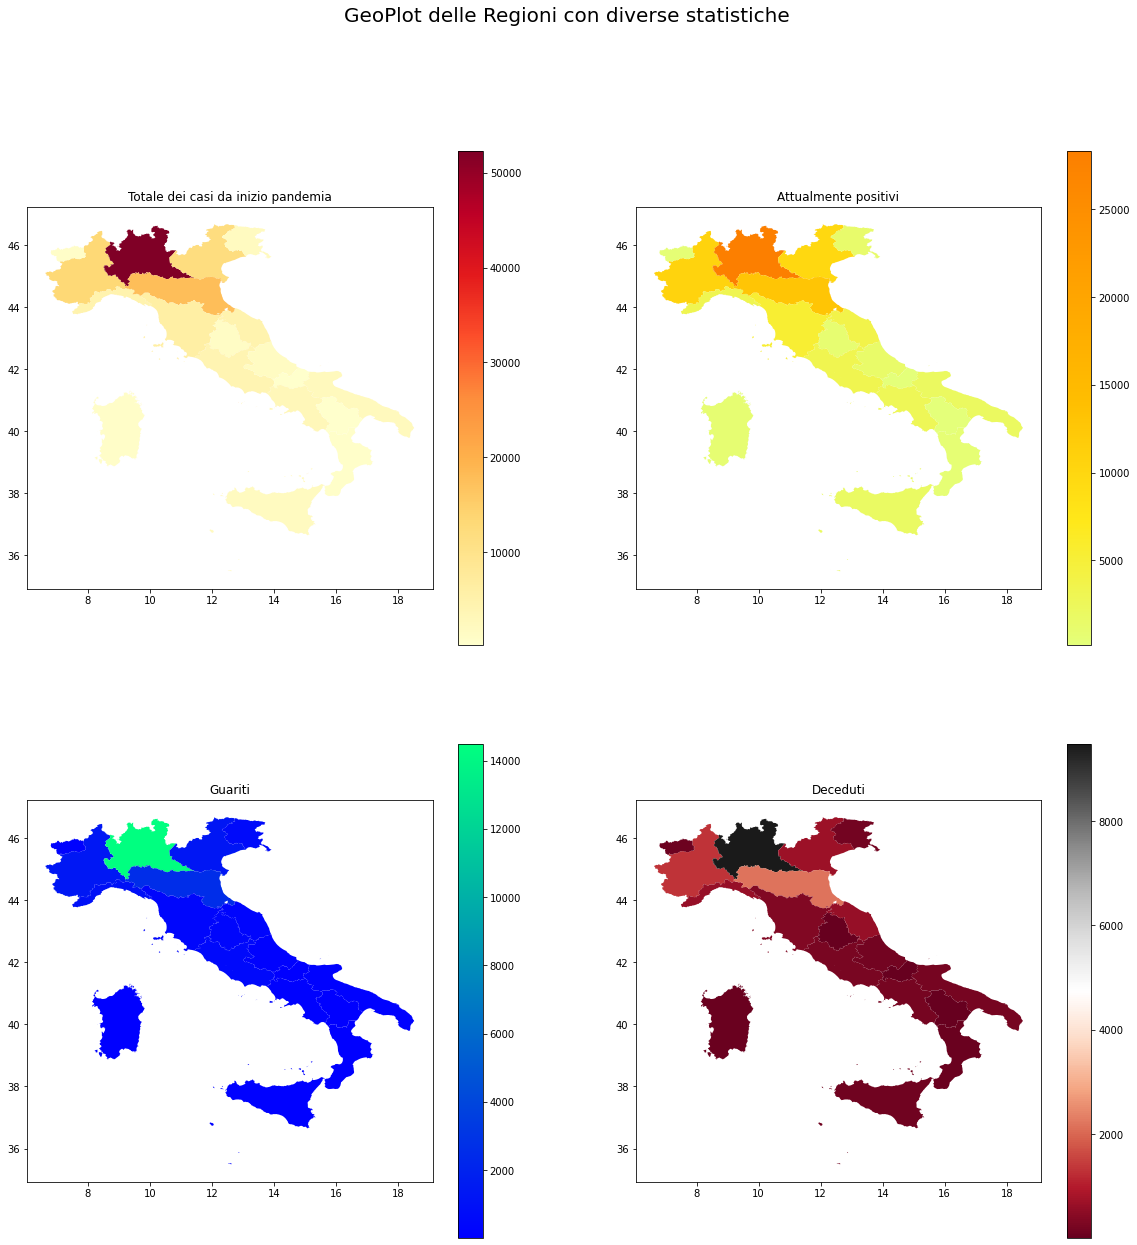

In [43]:
#@title *GeoPlot regioni italiane* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax[0][0].set_title('Totale dei casi da inizio pandemia')
gdf.plot(column='totale_casi', ax=ax[0][0], cmap='YlOrRd', legend=True)
ax[0][1].set_title('Attualmente positivi')
gdf.plot(column='totale_positivi', ax=ax[0][1], cmap='Wistia', legend=True)
ax[1][0].set_title('Guariti')
gdf.plot(column='dimessi_guariti', ax=ax[1][0], cmap='winter', legend=True)
ax[1][1].set_title('Deceduti')
gdf.plot(column='deceduti', ax=ax[1][1], cmap='RdGy', legend=True)
fig.suptitle('GeoPlot delle Regioni con diverse statistiche', fontsize=20)

In [44]:
#@title *Totale casi nelle regioni italiane* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig_bar_all_regions = px.bar(dati_regioni_latest, x='denominazione_regione', y='totale_casi')
fig_bar_all_regions.update_layout(title_text="Totale casi nelle regioni italiane aggiornato alla data: "+dati_regioni_latest['data'].values[0])
fig_bar_all_regions.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


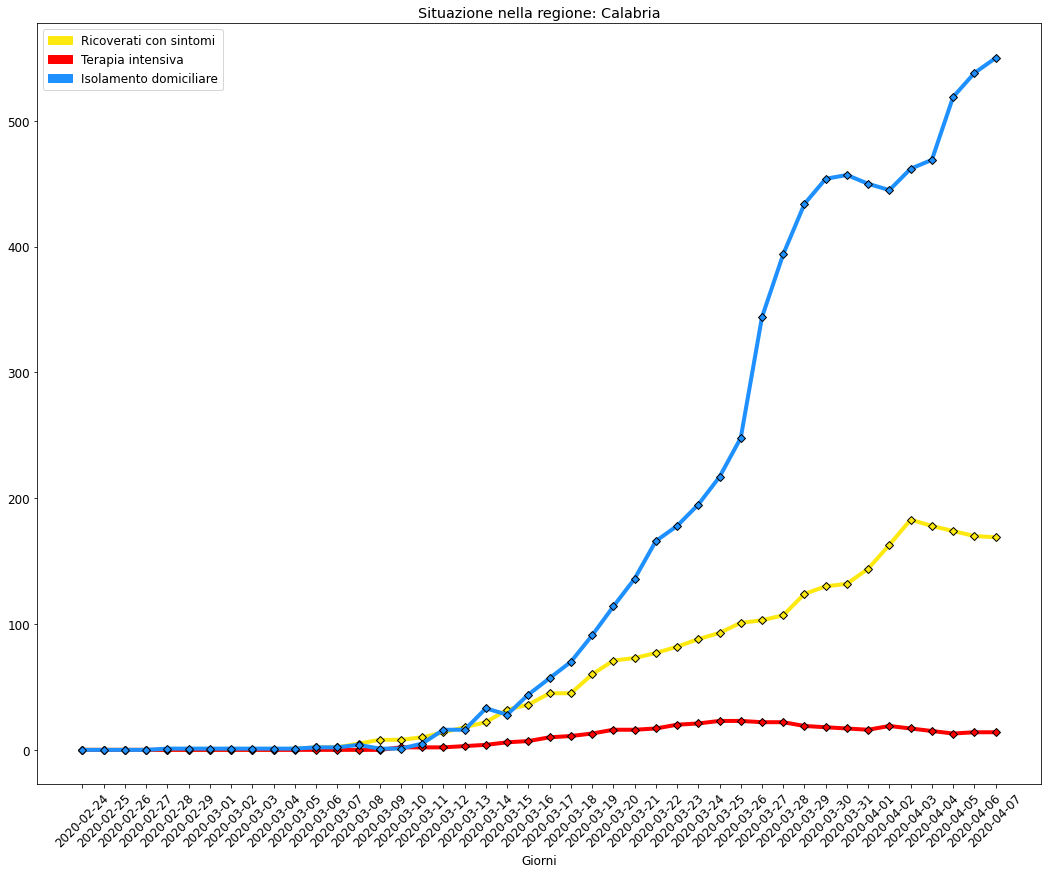

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


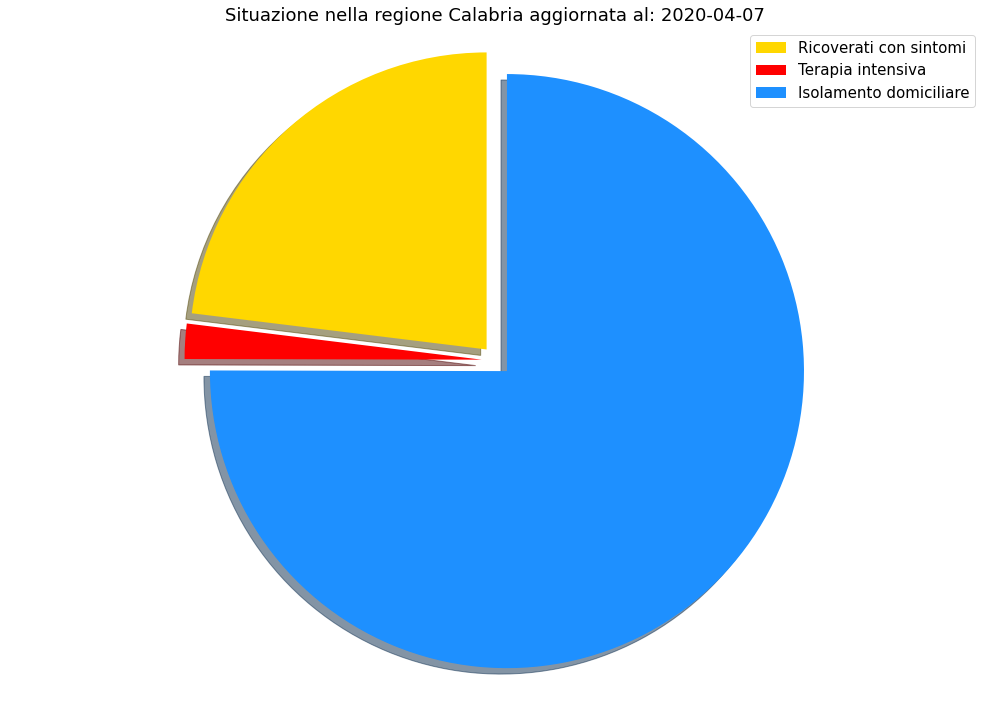

In [45]:
#@title *Andamento giornaliero (DA MODIFICARE): statistiche varie regione* 👀 Double click on this line to see code of plot { display-mode: "form" }

def plot_andamento_contagi_regione(regione):

  """
    Funzione che produce un plot dell'andamento dei contagi in una data regione

    Parameters:
    regione (string): regione da monitorare

  """

  giorno_regione = []
  ricoverati_con_sintomi_regione = []
  terapia_intensiva_regione = [] 
  isolamento_domiciliare_regione = []

  for day in dati_giornalieri_regioni:
    df_day_regioni = pd.read_csv(dati_regioni_path+str(day))

    is_region =  df_day_regioni['denominazione_regione'] == regione
    df_region = df_day_regioni[is_region]

    data = df_region['data'].values[0]

    f = "%Y-%m-%dT%H:%M:%S"
    conv=time.strptime(str(data),f)
    data_convertita = time.strftime("%Y-%m-%d",conv) # cambio formato alla data

    giorno_regione.append(data_convertita) # Giornata considerata
    ricoverati_con_sintomi_regione.append(df_region['ricoverati_con_sintomi'].values[0])
    terapia_intensiva_regione.append(df_region['terapia_intensiva'].values[0])
    isolamento_domiciliare_regione.append(df_region['isolamento_domiciliare'].values[0])


  font = {'family' : 'normal',
          'size'   : 12}
      
  plt.rc('font', **font)

  x = giorno_regione
  y1 = ricoverati_con_sintomi_regione
  y2 = terapia_intensiva_regione
  y3 = isolamento_domiciliare_regione


  plt.figure(figsize=(18,14))
  plt.xticks(rotation=45)
  plt.xlabel('Giorni')
  plt.title('Situazione nella regione: ' + regione)
  plt.plot(x, y1, color='#fde910', marker='D', markeredgecolor='black', linewidth=4)
  plt.plot(x, y2, color='red', marker='D', markeredgecolor='black', linewidth=4)
  plt.plot(x, y3, color='#1E90FF', marker='D', markeredgecolor='black', linewidth=4)

  red_patch = mpatches.Patch(color='#fde910', label='Ricoverati con sintomi')
  yellow_patch = mpatches.Patch(color='red', label='Terapia intensiva')
  blue_patch = mpatches.Patch(color='#1E90FF', label='Isolamento domiciliare')
  plt.legend(handles=[red_patch, yellow_patch,blue_patch])
  plt.show()

  # Scatter plot
  giorno_regione[-1] 
  ricoverati_con_sintomi_regione[-1]
  terapia_intensiva_regione[-1] 
  isolamento_domiciliare_regione[-1]

  tot_regione = ricoverati_con_sintomi_regione[-1]+terapia_intensiva_regione[-1]+isolamento_domiciliare_regione[-1] 

  percentuale_ricoverati_con_sintomi_regione = ricoverati_con_sintomi_regione[-1] / tot_regione
  percentuale_terapia_intensiva_regione = terapia_intensiva_regione[-1] / tot_regione
  percentuale_isolamento_domiciliare_regione = isolamento_domiciliare_regione[-1] / tot_regione

  font = {'family' : 'normal',
          'size'   : 15}
      
  plt.rc('font', **font)

  labels = ['Ricoverati con sintomi', 'Terapia intensiva', 'Isolamento domiciliare']
  sizes = [percentuale_ricoverati_con_sintomi_regione, percentuale_terapia_intensiva_regione, percentuale_isolamento_domiciliare_regione]
  colors = ['gold', 'red', '#1E90FF']
  plt.figure(figsize=(14,10))
  explode = list()
  for k in labels:
    explode.append(0.05)
  patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, explode=explode)
  plt.legend(patches, labels, loc="best")
  plt.title('Situazione nella regione ' + regione+' aggiornata al: '+str(giorno_regione[-1]))
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

  
plot_andamento_contagi_regione('Calabria')

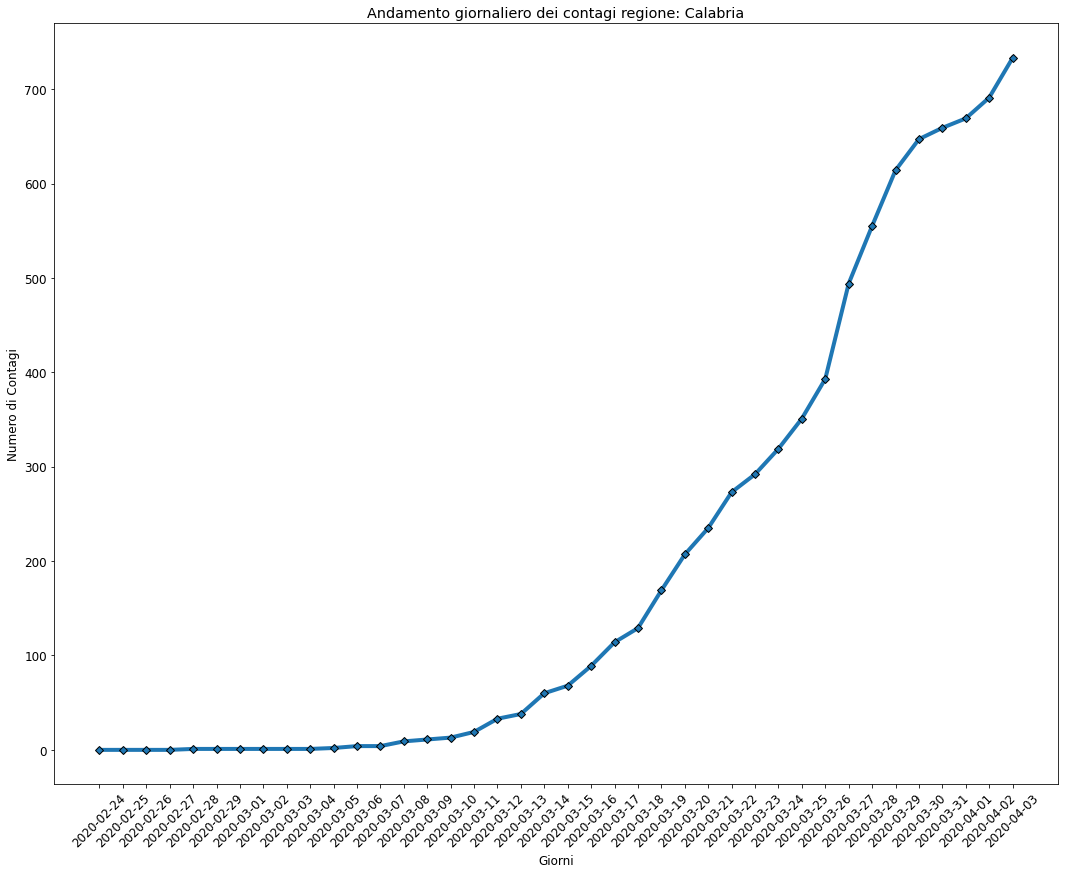

In [0]:
#@title *Andamento giornaliero contagi regione(DA MODIFICARE)* 👀 Double click on this line to see code of plot { display-mode: "form" }

def plot_andamento_contagi_regione(regione):

  """
    Funzione che produce un plot di statistiche in una data regione

    Parameters:
    regione (string): regione da monitorare

  """
  
  dati_giornalieri_regioni = []
  pattern = 'dpc-covid19-ita-regioni-\d+' # Regex con cui vado ad eliminare i csv non necessari 
  
  for x in sorted(dati_regioni): # Ordino la lista così da avere anche ordine cronologico
    if re.match(pattern, x):
      dati_giornalieri_regioni.append(x)

  date_total_regione = {}

  for day in dati_giornalieri_regioni:
    df_day_regioni = pd.read_csv(dati_regioni_path+str(day))

    is_region =  df_day_regioni['denominazione_regione'] == regione
    df_region = df_day_regioni[is_region]

    data = df_region['data'].values[0]

    f = "%Y-%m-%dT%H:%M:%S"
    conv=time.strptime(str(data),f)
    data_convertita = time.strftime("%Y-%m-%d",conv) # cambio formato alla data

    totale_contagi = df_region['totale_casi'].values[0]
    #print(data_convertita+" : "+str(totale_contagi))
    date_total_regione[data_convertita] = totale_contagi

  font = {'family' : 'normal',
          'size'   : 12}
      
  plt.rc('font', **font)

  x = list(date_total_regione.keys())
  y = list(date_total_regione.values())
  
  plt.figure(figsize=(18,14))
  plt.xticks(rotation=45)
  plt.xlabel('Giorni')
  plt.ylabel('Numero di Contagi')
  plt.title('Andamento giornaliero dei contagi regione: '+regione)
  plt.plot(x, y, marker='D', markeredgecolor='black', linewidth=4)
  plt.show()
  
plot_andamento_contagi_regione('Calabria')

In [0]:
#@title *Distribuzione casi nella regione* 👀 Double click on this line to see code of plot { display-mode: "form" }

fig_bar_regione = go.Figure([go.Bar(x=list(dati_regioni_province.keys()), y=list(dati_regioni_province.values()))])
fig_bar_regione.update_layout(title_text="Distribuzione casi nella regione: "+ regione_da_monitorare)
fig_bar_regione.show()

### Dati Provinciali

In [0]:
# Dataframe contenente tutti i dati delle provincie italiane aggiornati agli ultimi disponibili
dati_province_latest = pd.read_csv('/content/COVID-19/dati-province/dpc-covid19-ita-province-latest.csv')
dati_province_latest.head()

data stato  codice_regione  ... totale_casi  note_it note_en
0  2020-04-03T17:00:00   ITA              13  ...         310      NaN     NaN
1  2020-04-03T17:00:00   ITA              13  ...         166      NaN     NaN
2  2020-04-03T17:00:00   ITA              13  ...         669      NaN     NaN
3  2020-04-03T17:00:00   ITA              13  ...         418      NaN     NaN
4  2020-04-03T17:00:00   ITA              13  ...           0      NaN     NaN

[5 rows x 12 columns]

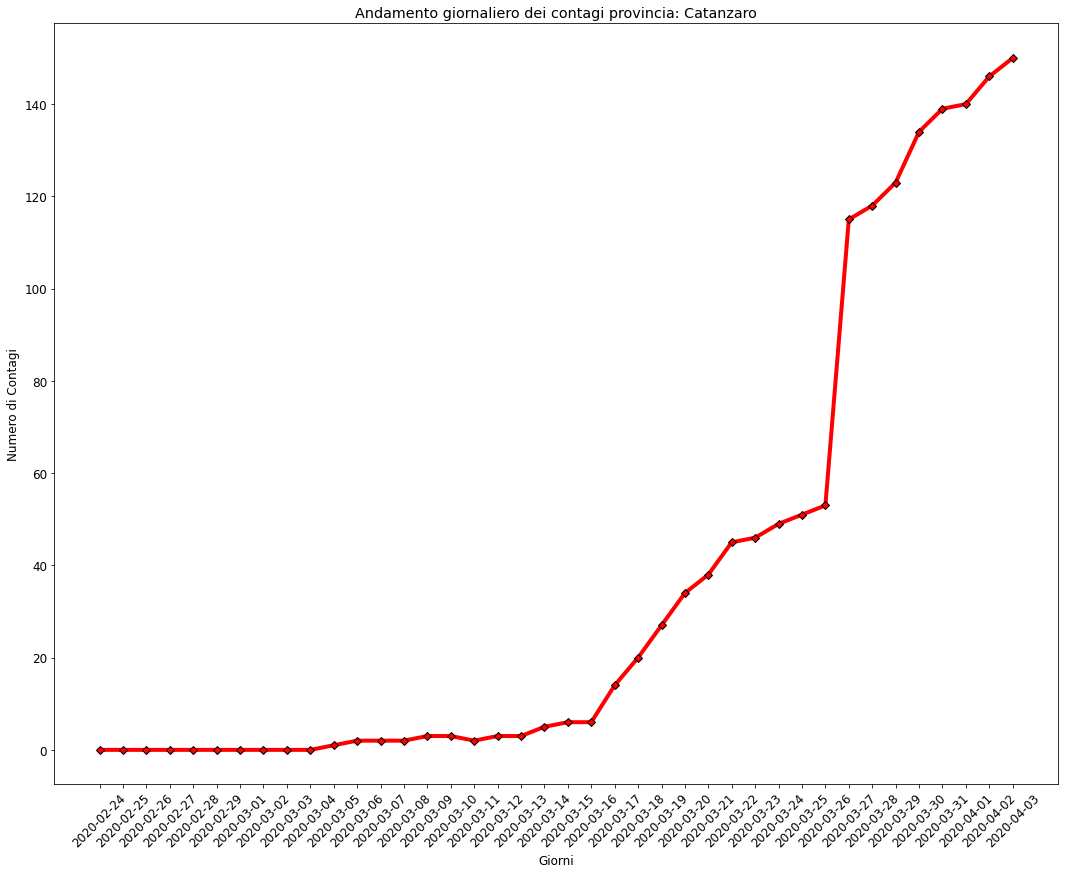

In [0]:
#@title *Andamento giornaliero contagi provincia(DA MODIFICARE)* 👀 Double click on this line to see code of plot { display-mode: "form" }


def plot_andamento_contagi_province(provincia):

  """
    Funzione che produce un plot dell'andamento dei contagi in una data provincia

    Parameters:
    provincia (string): provincia da monitorare

  """

  date_total_province = {}

  for day in dati_giornalieri_province:
    df_day_province = pd.read_csv(dati_province_path+str(day))

    is_provincia =  df_day_province['denominazione_provincia'] == provincia
    df_province = df_day_province[is_provincia]

    data = df_province['data'].values[0]

    f = "%Y-%m-%dT%H:%M:%S"
    conv=time.strptime(str(data),f)
    data_convertita = time.strftime("%Y-%m-%d",conv) # cambio formato alla data

    totale_contagi = df_province['totale_casi'].values[0]
    #print(data_convertita+" : "+str(totale_contagi))
    date_total_province[data_convertita] = totale_contagi

  font = {'family' : 'normal',
          'size'   : 12}
      
  plt.rc('font', **font)

  x = list(date_total_province.keys())
  y = list(date_total_province.values())
  
  plt.figure(figsize=(18,14))
  plt.xticks(rotation=45)
  plt.xlabel('Giorni')
  plt.ylabel('Numero di Contagi')
  plt.title('Andamento giornaliero dei contagi provincia: ' + provincia)
  plt.plot(x, y,color="red", marker='D', markeredgecolor='black', linewidth=4)
  plt.show()
  
plot_andamento_contagi_province('Catanzaro')

## Implementazione di un modello machine learning

Come prima fase di implementazione ho studiato alcuni modelli già esistenti come il seguente: [link git](https://github.com/lamharrison/coronavirus-machine-learning).

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(1337)

Using TensorFlow backend.


In [0]:
!pip install tensorflow==1.14.0 # Questioni di compatibilità

In [0]:
data_totale_contagi = {}

for giornata in dati_giornalieri:
  df = pd.read_csv(dati_andamento_nazionale_path+giornata)
  # Ho il dataframe per ogni giorno: Inizio con un semplice plot data totale casi
  data = df['data'].values[0]

  f = "%Y-%m-%dT%H:%M:%S"
  conv=time.strptime(str(data),f)
  data_convertita = time.strftime("%Y-%m-%d",conv) # cambio formato alla data

  totale_contagi = df['totale_casi'].values[0]
  #print(data_convertita+" : "+st8r(totale_contagi))
  data_totale_contagi[data_convertita] = totale_contagi

In [0]:
model = Sequential()
model.add(Dense(units=50, input_dim=1, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 2,703
Trainable params: 2,703
Non-trainable params: 0
_________________________________________________________________


In [0]:
dates = len(data_totale_contagi.values()) # Ho una serie di date. Alla x assegno le l'id della data considerata
x_value = list(range(1, dates + 1))

x_value = np.array(x_value)
y_value = np.array(list(data_totale_contagi.values()))
italy_dates_length = len(x_value)

# set italy absorb
totale_casi_italia = y_value[italy_dates_length-1]

y_value_norm = y_value / totale_casi_italia

In [0]:
model.fit(x_value, y_value_norm, epochs=5000, shuffle=False)

Streaming output truncated to the last 5000 lines.
37/37 [==============================] - 0s 145us/step - loss: 4.5003e-05
Epoch 2502/5000
37/37 [==============================] - 0s 136us/step - loss: 4.4224e-05
Epoch 2503/5000
37/37 [==============================] - 0s 143us/step - loss: 4.1163e-05
Epoch 2504/5000
37/37 [==============================] - 0s 157us/step - loss: 4.1544e-05
Epoch 2505/5000
37/37 [==============================] - 0s 132us/step - loss: 3.9543e-05
Epoch 2506/5000
37/37 [==============================] - 0s 132us/step - loss: 4.0198e-05
Epoch 2507/5000
37/37 [==============================] - 0s 131us/step - loss: 3.8809e-05
Epoch 2508/5000
37/37 [==============================] - 0s 148us/step - loss: 4.0693e-05
Epoch 2509/5000
37/37 [==============================] - 0s 145us/step - loss: 3.9658e-05
Epoch 2510/5000
37/37 [==============================] - 0s 161us/step - loss: 4.1905e-05
Epoch 2511/5000
37/37 [==============================] - 0s 148us

In [0]:
y_predict = model.predict(x_value)
y_predict = y_predict * totale_casi_italia

y_predict = np.array(y_predict)
y_predict = y_predict.astype(int)
y_predict.dtype

dtype('int64')

In [0]:
fig_reale_previsione = go.Figure()
fig_reale_previsione.add_trace(go.Scatter(x=x_value, y=y_value,
                    mode='lines',
                    name='Casi reali'))
fig_reale_previsione.add_trace(go.Scatter(x=x_value, y=y_predict.reshape(37),
                    mode='markers',
                    name='Risultato previsione'))

# Edit the layout
fig_reale_previsione.update_layout(title='Totale dei casi in italia',
                   xaxis_title='Date',
                   yaxis_title='Totale')

fig_reale_previsione.show()

Ho cercato di documentarmi su quali possibili algoritmi siano applicabili in queste tipologie di problemi. I dati da utilizzare per provare a creare un modello e fare una previsione sono la data e i casi totali relativi a quella data in modo da poter osservare la crescita della curva. In merito mi sono confrontato con un particolare problema presente nella biologia (**Exponential & logistic growth**). In questo campo si studia vome crescono le popolazioni quando hanno risorse illimitate (e come i limiti delle risorse cambiano quel modello). In particolare mi sono focalizzato sulla *logistic growth*: nella crescita logistica, il tasso di crescita pro capite di una popolazione diventa sempre più piccolo man mano che la dimensione della popolazione si avvicina al massimo imposto da risorse limitate nell'ambiente, noto come capacità di carico $\textit{K}$. Ritroviamo quindi dei pattern simili a quelli che si manifestano nella diffusione del **covid-19**. Un *logistic growth model* è chiamato anche *Verhulst model* in onore di P. F. Verhulst matematico belga che ha studiato questa idea nel 19esimo secolo applicandola alla crescita della popolazione degli Stati Uniti. Verhulst fece una previsione nel 1840 della popolazione degli Stati Uniti nel 1940 sbagliandosi di meno dell'1%. (Per approfondire: https://www.maa.org/book/export/html/115630). ![img](https://www.maa.org/sites/default/files/images/cms_upload/fig207282.gif)

La formula del *logistic growth model* si può sintetizzare come:

![formula](https://miro.medium.com/max/268/1*ktniY6tA5bAZrhRTkyWEBg.png)

in cui:

- y(t) numero di casi in un dato tempo t
- c è il valore limite, la capacità massima per y (numero infetti a fine epidemia)
- b deve essere maggiore di 0







### Implementazione modello : Logistic growth

In [0]:
x_value # Il timestamp 
y_value # Valore contagiati in Italia per un rispettivo timestamp

def logistic(t, a, b, c):
  return c / (1 + a * np.exp(-b*t))

p0 = np.random.exponential(size=3)
bounds = (0, [100000., 3., 100000000.]) # Valori presi da altri modelli esistenti

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.optimize import curve_fit,fsolve

(a,b,c),cov = curve_fit(logistic, x_value, y_value, bounds=bounds, p0=p0) # Ritorna i tre parametri che ci servono da passare alla logistic più la covarianza

y_pred = logistic(x_value,a,b,c).astype(int)

In [49]:
fig_logistica = go.Figure()
fig_logistica.add_trace(go.Scatter(x=x_value, y=y_value,
                    mode='lines',
                    name='Casi reali'))
fig_logistica.add_trace(go.Scatter(x=x_value, y=y_pred,
                    mode='markers',
                    name='Risultato previsione'))

# Edit the layout
fig_logistica.update_layout(title='Logistic model vs osservazioni reali in Italia',
                   xaxis_title='Timestamp',
                   yaxis_title='Contagi')

fig_logistica.show()

In [0]:
previsioni_prossima_settimana = []

for i in range(7):
  previsioni_prossima_settimana.append(logistic(i+38,a,b,c))

# Previsione per i prossimi 7 giorni
fig_previsioni = go.Figure()
fig_previsioni.add_trace(go.Scatter(x=[0,1,2,3,4,5,6], y=previsioni_prossima_settimana,
                    mode='lines+markers',
                    name='Casi reali'))

# Edit the layout
fig_previsioni.update_layout(title='Previsione contagi totali Italia prossima settimana',
                   xaxis_title='Giorno',
                   yaxis_title='Contagi')

fig_previsioni.show()

In [54]:
# PREVISIONE CON DATI AGGIORNATI AL 7 APRILE 2020: Voglio vedere i cambiamenti:

previsioni_prossima_settimana_aggiornamento = []

for i in range(7):
  previsioni_prossima_settimana_aggiornamento.append(logistic(i+46,a,b,c))

# Previsione per i prossimi 7 giorni
fig_previsioni_aggiornata = go.Figure()
fig_previsioni_aggiornata.add_trace(go.Scatter(x=[0,1,2,3,4,5,6], y=previsioni_prossima_settimana_aggiornamento,
                    mode='lines+markers',
                    name='Casi reali'))

# Edit the layout
fig_previsioni_aggiornata.update_layout(title='Previsione contagi totali Italia prossima settimana con dati aggiornati per vedere differenza',
                   xaxis_title='Giorno',
                   yaxis_title='Contagi')

fig_previsioni_aggiornata.show()

Per capirci meglio stiamo considerando il parametro CASI TOTALI in basso nella tabella:
 ![alt](https://i2.wp.com/www.liberoreporter.it/wp-content/uploads/2020/03/covid-31marzo.jpg?resize=890%2C728&ssl=1) 

In [0]:
logistic(38,a,b,c)-105792

3713.4870629477955

La previsione calcola i contagi totali che a prossima settimana si attestano su **122.533** (non si considerano defunti o guariti). Il parametro *c* (massimo numero di contagi si attesta) a **130721**. Certo è un modello semplice e non veritiero probabilmente ma dimostra come il machine learning ci viene incontro nella soluzione di problemi di vita reale.

### Modello numero2 : The Susceptible-Infected-Recovered (SIR) model (Ancora ci devo lavorare su)

In [0]:
# Parto sempre dai soliti dati: 
df_andamento_nazionale.iloc[0] #Primo dato disponibile
df # Ultimo df andamento nazionale disponibile

Popolazione_Italiana = 60317116 # dati popolazione italiana presi da Istat

R = df.dimessi_guariti.values + df.deceduti.values # The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased.
I = df.totale_positivi.values # This person has contracted the disease
S = Popolazione_Italiana - R - I # The individual hasn't contracted the disease

'''
df_andamento_nazionale.iloc[0].dimessi_guariti
R = df_andamento_nazionale.iloc[0].dimessi_guariti + df_andamento_nazionale.iloc[0].deceduti
I = df_andamento_nazionale.iloc[0].totale_positivi
S = Popolazione_Italiana - R - I
'''

'\ndf_andamento_nazionale.iloc[0].dimessi_guariti\nR = df_andamento_nazionale.iloc[0].dimessi_guariti + df_andamento_nazionale.iloc[0].deceduti\nI = df_andamento_nazionale.iloc[0].totale_positivi\nS = Popolazione_Italiana - R - I\n'

In [0]:
from scipy.integrate import odeint

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2417, 0.037
# A grid of time points (in days)
#t = np.linspace(0, 120, 120)
t = np.arange(0,120)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S[0], I[0], R[0]
#y0 = S, I, R
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(Popolazione_Italiana, beta, gamma))
S, I, R = ret.T

In [0]:
fig_SIR = go.Figure()
fig_SIR.add_trace(go.Scatter(x=t, y=S,
                    mode='lines+markers', marker_color='blue',
                    name='Susceptible'))
fig_SIR.add_trace(go.Scatter(x=t, y=I,
                    mode='lines+markers', marker_color='red',
                    name='Infected'))
fig_SIR.add_trace(go.Scatter(x=t, y=R,
                    mode='lines+markers', marker_color='green',
                    name='Recovered with immunity'))

# Edit the layout
fig_SIR.update_layout(title='SIR model Italy update at: '+ df_andamento_nazionale["data"].iloc[-1],
                   xaxis_title='Time/Days')

fig_SIR.show()